In [46]:
import pickle
import pandas as pd
import numpy as np
import csv
import matplotlib as mp
import matplotlib.pyplot as plt
from numpy.lib import recfunctions
import datetime
import numpy.lib.recfunctions as recfn
import boto3
import sys
from IPython.display import clear_output
from scipy import stats, fftpack
from scipy.stats import kurtosis, skew, iqr, t
import pickle
from scipy import io as sio
s3 = boto3.resource('s3')
from io import BytesIO
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest
import seaborn as sns

FLGHTLEN = .75 # Filter out anything that is less than this flight time
IN_BKT = 'iia-vault-telemetry-practice-unzipped'
SMPL_SIZES= [.01,.01,.1,.1]
RANDSEED= 42 # Urban Data Science Myth- Apparently gives best results!!
# NUMOFVARS= 30 # Number of variables from the mat files to be selected
PRINTATEVERY= 2500 # Key Values

# Introduction

In this notebook we read back features created and use sci-kit learn to build a Isolation Forest Anomaly detection model.

Anomaly detection falls in the area of unsupervised learning. In unsupervised learning you don't have a label/ number that you look to predict. Usually the data helps instances, in our a flight take off stand out based on the features selected and the base data signatures.

In the case of unsupervised learning the machine learning model output needs to be validated with ground truth

## Pickle -> Python Dictionary -> Dataframe

The following function converts the pickle file to usable python pandas dataframe

In [4]:
def pikl_dict_df(pkl_file):
    with open(pkl_file, 'rb') as f:
        dd = pickle.load(f)
    rows=[]
    for k1, v1 in dd.items():
        for k2,v2 in v1.items():
            val_series=[]
            for k3,v3 in v2.items():
                for k4,v4 in v3.items():
                    rows.append([k1, k3+'_'+k4, v4])
    df= pd.DataFrame(rows, columns= ['Flight', 'Metrics', 'Values']).\
    pivot(index= 'Flight', columns='Metrics', values='Values')
    for col in df.columns:
        if 'GESD' in col:
            new_cols= [col+'_'+'1', col+'_'+'2', col+'_'+'3']
            s=pd.DataFrame(df[col].values.tolist(), columns= new_cols, index= df.index)
            df.drop(columns=col, inplace= True)
            df= pd.concat([df,s], ignore_index= False, axis=1)
    return(df)

In [5]:
train= pikl_dict_df('flight_stats_prt2_1pct.pickle')

In [27]:
#test= pikl_dict_df('flight_stats_prt1_1pct.pickle')

# Features

The choice of features depends on optimal performance of a model. The following features are calculated in the earlier exercise

***To Do:***
Open a new cell and type any one of the feature set to see the contents

In [6]:
f1= train.columns.tolist()
f2= [c for c in train.columns if 'ALTR'in c]
f3= [c for c in train.columns if 'sin' not in c]
f3= [c for c in f3 if 'cos' not in c]
f4= [c for c in train.columns if 'GESD' not in c]
f5= [c for c in train.columns if 'WS'in c and 'GESD' not in c]
f6= [c for c in train.columns if 'ALTR' in c and 'GESD' not in c]
f6= f6+[c for c in train.columns if 'WS' in c and 'GESD' not in c]
f7= ['ALTR_mean','WS_mean']

# Isolation Forest

A detailed description is available  <a href="https://blog.paperspace.com/anomaly-detection-isolation-forest/" target="_blank"> here</a>

Sci-kit learn page <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html" target="_blank"> here</a>

## HyperParameters

* Number of estimators: n_estimators refers to the number of base estimators or trees
* Max samples: max_samples is the number of samples to be drawn to train each base estimator.
* Contamination: This is a parameter that the algorithm is quite sensitive to; it refers to the expected proportion of outliers in the data set. 
* Max features: All the base estimators are not trained with all the features available in the dataset.

In [26]:
def isolationforest_harness(train, features=f6, num_estimators=50, c= float(0.01)):
    model=IsolationForest(n_estimators= num_estimators, max_samples='auto', \
                          contamination= c,max_features=len(features)-1)
    model.fit(train.loc[:,features].values)
    train['scores']=model.decision_function(train.loc[:,features])
    train['anomaly']=model.predict(train.loc[:,features])
    anomaly= train.loc[train['anomaly']==-1]
    anomaly_index=list(anomaly.index)
    rownum=[]
    for a in anomaly_index:
        rownum.append(np.where(train.index==a)[0][0])
    return(anomaly_index, rownum, train)

***TO Do:***
Let's do the following:
- Change the c value to 0.001
- Use a different feature set

In [27]:
anomaly_index, rownum, df= isolationforest_harness(train)

Text(0, 0.5, 'Scores')

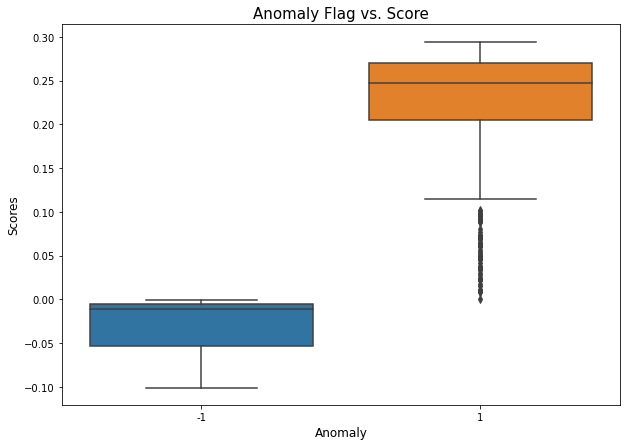

In [28]:
plt.figure(figsize=(10,7))
plt.title('Anomaly Flag vs. Score', fontsize=15)
sns.boxplot(x="anomaly", y="scores", data=df)
plt.xlabel('Anomaly',fontsize=12)
plt.ylabel('Scores',fontsize=12)

In [11]:
rownum

[3, 56, 347, 434, 479, 484]

In [71]:
train['anomaly'].value_counts()

 1    566
-1      6
Name: anomaly, dtype: int64

In [12]:
train.loc[train['anomaly']==-1]

,ALTR_iqr,ALTR_kurt,ALTR_mean,ALTR_skew,ALTR_uniques,ALTR_variance,AOA1_cos_iqr,AOA1_cos_kurt,AOA1_cos_mean,AOA1_cos_skew,...,ROLL_cos_GESD_2,ROLL_cos_GESD_3,ROLL_sin_GESD_1,ROLL_sin_GESD_2,ROLL_sin_GESD_3,WS_GESD_1,WS_GESD_2,WS_GESD_3,scores,anomaly
Flight,,,,,,,,,,,,,,,,,,,,,
Flight 652/1/652200106201414,128,28.5583,10.5918,3.42105,88,62341,0.0133221,-0.69794,0.991808,-0.620851,...,15.646000,1060.0,4.056149,5.546281,1060.0,4.056149,5.558183,1052.0,-0.027371,-1
Flight 653/6/653200301181259,16,187.747,1.83139,13.2462,42,19150.5,0.000539165,0.604678,0.99066,-1.60846,...,31.976640,2913.0,4.292848,11.738123,2913.0,4.292848,15.478411,2908.0,-0.010521,-1
Flight 661/8/661201007181133,96,29.5819,96.8846,5.31148,55,322871,4.94133e-05,27.0152,0.999575,-4.8157,...,14.951294,405.0,3.813908,9.535340,405.0,3.813908,3.720244,403.0,-0.026910,-1
Flight 664/1/664200106051425,0,-3,-32,0,1,0,0,-3,0.997825,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002616,-1
Flight 665/4/665200205061836,48,164.396,-3.33653,11.5696,39,6586.7,0.00112917,111.556,0.999372,-7.84275,...,15.905592,3746.0,4.349349,5.435240,3746.0,4.349349,9.258077,3718.0,-0.067420,-1
Flight 665/4/665200207101438,128,2.2855,9.31844,-0.825515,336,1.22015e+06,0.000846791,113.763,0.998913,-6.28152,...,5.497915,4314.0,4.384243,4.790303,4314.0,4.384243,2.020202,4265.0,-0.109410,-1


In [44]:
norms= df[(df['scores'] >= .23) & (df['scores'] <= .232)]
norm_idx= norms.index
norms

,ALTR_iqr,ALTR_kurt,ALTR_mean,ALTR_skew,ALTR_uniques,ALTR_variance,AOA1_cos_iqr,AOA1_cos_kurt,AOA1_cos_mean,AOA1_cos_skew,...,ROLL_cos_GESD_2,ROLL_cos_GESD_3,ROLL_sin_GESD_1,ROLL_sin_GESD_2,ROLL_sin_GESD_3,WS_GESD_1,WS_GESD_2,WS_GESD_3,scores,anomaly
Flight,,,,,,,,,,,,,,,,,,,,,
Flight 654/5/654200210091432,96,56.1165,27.0312,7.06397,66,110911,0.00070553,152.574,0.998018,-11.8795,...,25.045379,1023.0,4.045819,16.491006,1023.0,4.045819,8.651525,1010.0,0.230220,1
Flight 656/2/656200107170706,32,32.0371,40.1509,5.69167,33,78343.9,0,97.9876,0.998703,-9.53626,...,4.887030,228.0,3.878500,3.180960,438.0,3.878500,10.383848,528.0,0.230991,1
Flight 659/4/659200206041727,80,67.2142,6.67275,7.35509,55,29213.5,0.00146868,55.937,0.998723,-6.1415,...,25.187959,1307.0,4.106499,16.552864,1307.0,4.106499,10.728104,1288.0,0.231556,1
Flight 661/5/661200208031752,48,89.4377,13.3545,9.12125,44,49341.2,0.000111672,24.6845,0.997335,1.25703,...,18.552579,1257.0,4.095994,8.168127,1257.0,4.095994,11.284433,1256.0,0.231588,1


# 2 Dimensional PCA Plot

PCA is a dimension reduction technique that projects a data set into a plane such that the 2 dimensional axis aligns with maximum variances 

In [13]:
from sklearn.decomposition import PCA
def pcs_plot(rownum, train, features= f6):
    plt.figure(figsize=(15,8))
    pca = PCA(2)
    pca.fit(train.loc[:,features])
    res=pd.DataFrame(pca.transform(train.loc[:,features]))
    Z = np.array(res)
    plt.title("IsolationForest",fontsize=18)
    plt.contourf( Z, cmap=plt.cm.Blues_r)
    b1 = plt.scatter(res[0], res[1], c='cyan',s=20,label="normal points", marker='o')
    b1 = plt.scatter(res.iloc[rownum,0],res.iloc[rownum,1], c='orange',s=60,  edgecolor="red",label="predicted outliers", marker='*')
    plt.legend(loc="upper right",fontsize=12)
    plt.xlabel('PCA Component 1',fontsize=12)
    plt.ylabel('PCA Component 2',fontsize=12)
    plt.grid(which= 'major')
    plt.show()

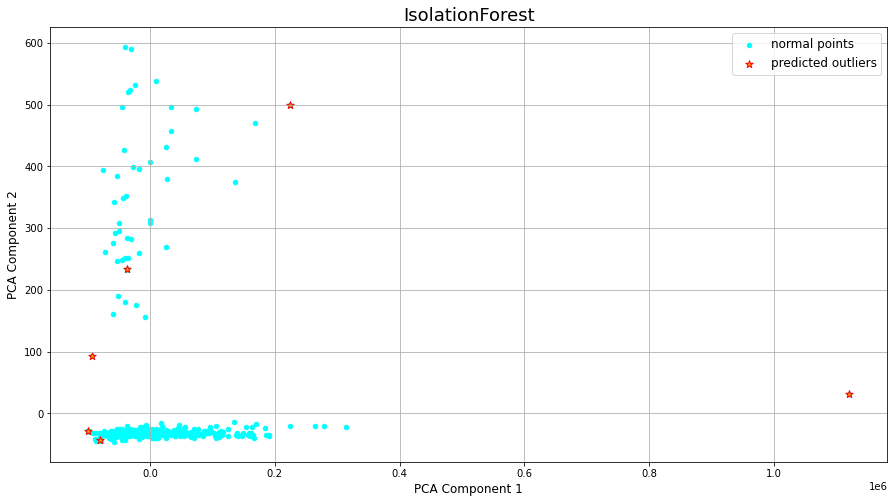

In [14]:
pcs_plot(rownum, train)

# Investigating Anomalies

As discussed investigating ground truth is key for unsupervised learning. 
The following codes help in understanding some of the underlying challenges. 

***To Do:***
Use the codes below to investigate and isolate challenges with the take offs. Watch out!! So of it might be data issues

In [47]:
def s3_bucket_object_keys(bucket_name= IN_BKT):
    bucket = s3.Bucket(bucket_name)
    key_list=[]
    for key in bucket.objects.all():
        key_list.append(key)
    sorted(key_list, key = lambda x: int(x.key[16:28]))
    return(key_list)

In [48]:
key_list = s3_bucket_object_keys()

In [51]:
def find_flight_keys(key_list, fliers):
    outflights=[]
    for key in key_list:
        for o in fliers:
            if o+'.mat' == key.key:
                outflights.append(key)
    return(outflights)

In [53]:
inflights= find_flight_keys(key_list, norm_idx)
outflights = find_flight_keys(key_list, anomaly_index)

In [54]:
def find_

[s3.ObjectSummary(bucket_name='iia-vault-telemetry-practice-unzipped', key='Flight 654/5/654200210091432.mat'),
 s3.ObjectSummary(bucket_name='iia-vault-telemetry-practice-unzipped', key='Flight 656/2/656200107170706.mat'),
 s3.ObjectSummary(bucket_name='iia-vault-telemetry-practice-unzipped', key='Flight 659/4/659200206041727.mat'),
 s3.ObjectSummary(bucket_name='iia-vault-telemetry-practice-unzipped', key='Flight 661/5/661200208031752.mat')]